In [4]:
import numpy as np
from scipy.special import factorial2
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

In [5]:
class Sphere:
    
    def __init__(self, dim, r):
        self.dim = dim
        self.r = r
        if dim % 2 == 1:
            self.area = 2**((self.dim + 1)/2)*np.pi**((self.dim - 1)/2) / (factorial2(dim - 2))
        else:
            self.area = (2*(np.pi)**(self.dim / 2))/ np.math.factorial(int(0.5*self.dim - 1))
            
    def sample(self, nsamps, noise = 0):
        u = 2*np.random.rand(nsamps, self.dim)-1
        unorm = np.linalg.norm(u, keepdims = True, axis = 1)
        s = u / unorm
        if noise:
            w = np.random.randn(nsamps, self.dim)
            s += noise*w
        return s
    
    def grid(self, n):
        assert self.dim == 2, 'Grid only supported for dim = 2.'
        endpoint = (2*np.pi*(n - 1))/ n
        theta = np.linspace(0, endpoint, n)
        x, y = self.r*np.cos(theta), self.r*np.sin(theta)
        circle = np.vstack([x,y]).T
        return theta, circle
    
    def _show_circle(self,circle, random_signal = False):
        x, y = circle[:,0], circle[:,1]
        c = np.random.randn(len(x)) if random_signal else None
        plt.scatter(x, y, c = c)            
        plt.gca().set_aspect('equal')
        if random_signal:
            cb = plt.colorbar()
            cb.set_label('$f$')
        plt.show()
        plt.close()
    
    def show_grid(self, n, random_signal = False):
        assert self.dim == 2, 'Plotting only supported for dim = 2.'
        theta, circle = self.grid(n)
        self._show_circle(circle, random_signal)
        return theta, circle 
        
    def show_samples(self, nsamps, noise = 0):
        assert self.dim == 2, 'Plotting only supported for dim = 2.'
        s = self.sample(nsamps, noise)
        self._show_circle(s)
        return s
    
class Filter:
    
    def __init__(self, size, values):
        assert size % 2 == 1, 'Filter size must be odd.'
        assert size == len(values), 'Length of values must match size.'
        self.size = size
        self.h = int((size - 1) / 2)
        self.values = values
        
    def convolve(self, f):
        #breakpoint()
        signal_size = len(f)
        h = np.zeros(signal_size)
        for i in range(signal_size):
            first_ind, last_ind = (i - self.h), (i + self.h)
            inds = np.linspace(first_ind, last_ind, self.size, dtype = int) % signal_size
            f_window = f[inds]
            val = (self.values*f_window).sum()
            h[i] = val
        return h
    
    def show_convolution(self, f):
        h = self.convolve(f)
        fig, ax = plt.subplots(1,3)
        ax[0].plot(f)
        ax[0].set_title('Signal')
        ax[1].plot(self.values)
        ax[1].set_title('Filter')
        ax[2].plot(h)
        ax[2].set_title('Convolution')
        plt.tight_layout()
        plt.show()
        plt.close()
        return h
    
class LocalPCA:
    
    def __init__(self, dim, k):
        self.pca = PCA(n_components = dim, whiten = True)
        self.knn = NearestNeighbors(n_neighbors = k)
        
    def fit(self, X):
        frames = []
        self.knn.fit(X)
        groups = self.knn.kneighbors_graph(X).toarray()
        for group in groups:
            group = [i for i in range(len(group)) if group[i] == 1]
            group = np.array(group, dtype = int)
            x = X[group]
            self.pca.fit(x)
            vecs = self.pca.components_
            frames.append(vecs)
        return frames
    
    def show_frame(self, inds, X):
        frames = self.fit(X)
        plt.scatter(X[:,0], X[:,1], s = 2)
        for i in inds:
            x, y = X[i]
            dx, dy = frames[i].flatten()
            plt.arrow(x, y, dx, dy)
        plt.gca().set_aspect('equal')
        plt.show()
        plt.close()
        return frames
    

def _normal2d(vecs):
    return np.vstack([-vecs[:,1], vecs[:,0]]).T

def _normal3d(vecs):
    A, B = np.array([v[0] for v in vecs]), np.array([v[1] for v in vecs])
    return np.cross(A, B)
    
def _projSxM(x, normal):
    
    projx = np.outer(x,x)
    projNx = np.outer(normal, normal)
    
    dim = x.shape[0]
    proj = np.zeros((dim**2,dim**2))
    std_basis = np.eye(dim)
    
    basis_ind = 0
    for i in range(dim):
        for j in range(dim):
            basis_elem = np.outer(std_basis[i,:], std_basis[j,:])
            img_of_basis_elem = projNx @ basis_elem @ projx
            img_of_basis_elem = img_of_basis_elem.flatten()
            proj[:,basis_ind] = img_of_basis_elem
            basis_ind += 1
    return proj

def _sum_projSxM(X, normals):
    dim = X.shape[1]
    sum_proj = np.zeros((dim**2,dim**2))
    for x, normal in zip(X, normals):
        sum_proj += _projSxM(x, normal)
    return sum_proj

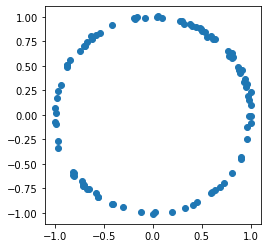

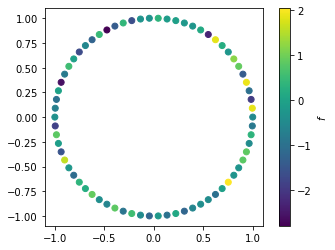

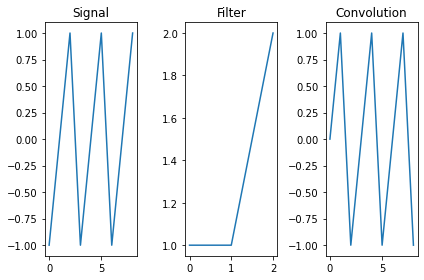

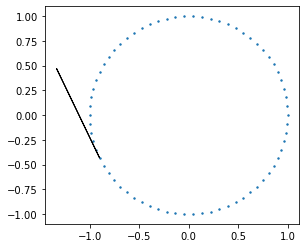

[17.5 35.   0.  17.5]
[[-7.07106781e-01  0.00000000e+00 -3.81308169e-17  7.07106781e-01]
 [-7.07106781e-01  0.00000000e+00  3.81308169e-17 -7.07106781e-01]
 [ 1.79439138e-17 -7.07106781e-01  7.07106781e-01 -3.18960837e-17]
 [ 5.87220220e-02 -7.04664263e-01 -7.04664263e-01 -5.87220220e-02]]


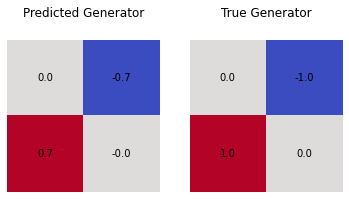

In [6]:
dim, r = 2, 1
sphere = Sphere(dim, r)
s = sphere.show_samples(100, noise = 0.01)
theta, circle = sphere.show_grid(70, random_signal = True)
f = np.array([-1,0,1, -1,0,1, -1,0,1])
values = [1, 1, 2]
filt = Filter(3, values)
h = filt.show_convolution(f)

localpca = LocalPCA(1, 5)
frames = localpca.show_frame([40], circle)
tangents = np.vstack(frames)
normals = _normal2d(tangents)

P = _projSxM(circle[0], normals[0])
sumP = _sum_projSxM(circle, normals)
w, v = np.linalg.eig(sumP)

# eigenvector with smallest eigenvalue should be around (0, -1, 1, 0)
print(w)
print(v.T)
A, truth = v[:,2].reshape((2,2)), np.array([[0, -1],[1, 0]])

fig, ax = plt.subplots(1,2)
ax[0].matshow(A, cmap = 'coolwarm')
ax[0].axis('off')
ax[0].set_title('Predicted Generator')

for (i, j), z in np.ndenumerate(A):
    ax[0].text(j, i, '{:0.1f}'.format(z), ha='center', va='center', color = 'black')

ax[1].matshow(truth, cmap = 'coolwarm')
ax[1].axis('off')
ax[1].set_title('True Generator')

for (i, j), z in np.ndenumerate(truth):
    ax[1].text(j, i, '{:0.1f}'.format(z), ha='center', va='center', color = 'black')


plt.show()
plt.close()

In [27]:
# sphere
dim, r = 3, 1
sphere = Sphere(dim, r)
point_cloud = sphere.sample(4000)

localpca = LocalPCA(2, 20)
frames = localpca.fit(point_cloud)
normals = _normal3d(frames)
sumP = _sum_projSxM(point_cloud, normals)
w, v = np.linalg.eig(sumP)